In [11]:
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.bandstructure import BandStructure
from pymatgen.electronic_structure.plotter import BSPlotter
import numpy as np
import matplotlib.pyplot as plt

In [12]:
print("Création de la structure de bande...")
with MPRester("stzwdugeNELjqCAkcHa") as mpr:
    band_struct_sl = mpr.get_bandstructure_by_material_id(material_id="mp-11327")
symm_line_dict = band_struct_sl.as_dict()
b_struct = BandStructure.from_dict(symm_line_dict)
plotter = BSPlotter(band_struct_sl)
print("Terminé")

Création de la structure de bande...
Terminé


In [13]:
# Band gap
b_g = b_struct.get_band_gap() # dict : {'direct': False, 'energy': 1.7961, 'transition': 'X-\\Gamma'}
print("La bande interdite est de", b_g['energy'], "eV")
if b_g['direct']:
    print("Le gap (direct) est visible dans le plot suivant")
else:
    print("Le gap (indirect) est visible dans le plot suivant")

La bande interdite est de 1.7961 eV
Le gap (indirect) est visible dans le plot suivant


Affichage de la zone de Brillouin


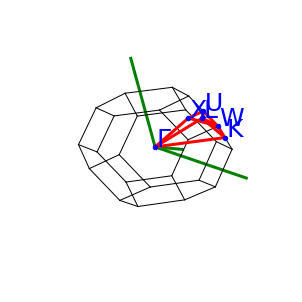

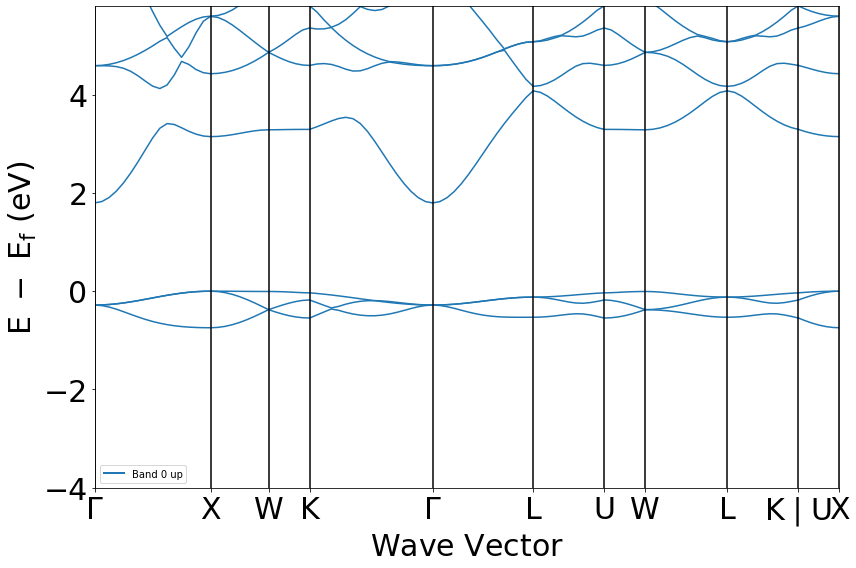

In [14]:
print("Affichage de la zone de Brillouin")
plotter.plot_brillouin()
plotter.show()

In [15]:
# Dispersion

data = plotter.bs_plot_data()
all_dist = data['distances']
E_bands = data['energy']['1']
# We store absolute values of displacement, energy and informations to show
dist_in_k = np.array([])
E_val = np.array([])
E_cond = np.array([])
slope_seg_v = {"min_slope" : [None, 0, 0, 0, 0], "max_slope" : [0, 0, 0, 0, 0]} # slope + start_coord (k, E) + increase (dk, dE)
slope_seg_c = {"min_slope" : [None, 0, 0, 0, 0], "max_slope" : [0, 0, 0, 0, 0]}
# Index of the bands
band_v = 11 # max index is b_struct.nb_bands-1=95
band_c = 12
# Loop and store values of E_cond and E_val
label_ind = 0
for part in range(len(all_dist)) :#nombre de frontières de chemin
    # Retrieve from data
    k = all_dist[part]
    E_v = E_bands[part][band_v]
    E_c = E_bands[part][band_c]
    #while label_ind+1 < len(labels) and labels[label_ind+1]==labels[label_ind+1]:
    #    label_ind += 1
    k_lim = (k[0], k[-1])
    # Numerical calculation of the derivatives
    i = np.arange(len(k)-1)
    dist_in_k = np.hstack((dist_in_k, k[i]))
    der1_val =  (E_v[i+1]-E_v[i])/(k[i+1]-k[i])
    der1_cond = (E_c[i+1]-E_c[i])/(k[i+1]-k[i])
    E_val =  np.hstack(( E_val,  E_v[i] ))
    E_cond = np.hstack(( E_cond, E_c[i] ))
    # Undate mean slope
    mean_d_v = sum(der1_val)/(len(k)-1)
    mean_d_c = sum(der1_cond)/(len(k)-1)
    if (slope_seg_v["min_slope"][0] is None or abs(slope_seg_v["min_slope"][0]) > abs(mean_d_v)):
        slope_seg_v["min_slope"] = [mean_d_v, k[0], E_v[0], k[-1]-k[0], E_v[-1]-E_v[0]]
    if (slope_seg_c["min_slope"][0] is None or abs(slope_seg_c["min_slope"][0]) > abs(mean_d_c)):
        slope_seg_c["min_slope"] = [mean_d_c, k[0], E_c[0], k[-1]-k[0], E_c[-1]-E_c[0]]
    if abs(slope_seg_v["max_slope"][0]) < abs(mean_d_v):
        slope_seg_v["max_slope"] = [mean_d_v, k[0], E_v[0], k[-1]-k[0], E_v[-1]-E_v[0]]
    if abs(slope_seg_c["max_slope"][0]) < abs(mean_d_c):
        slope_seg_c["max_slope"] = [mean_d_c, k[0], E_c[0], k[-1]-k[0], E_c[-1]-E_c[0]]


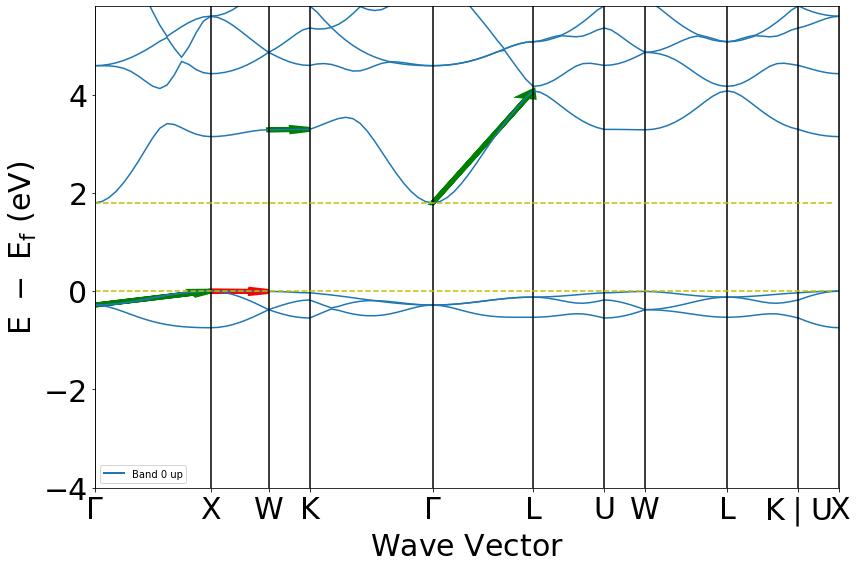

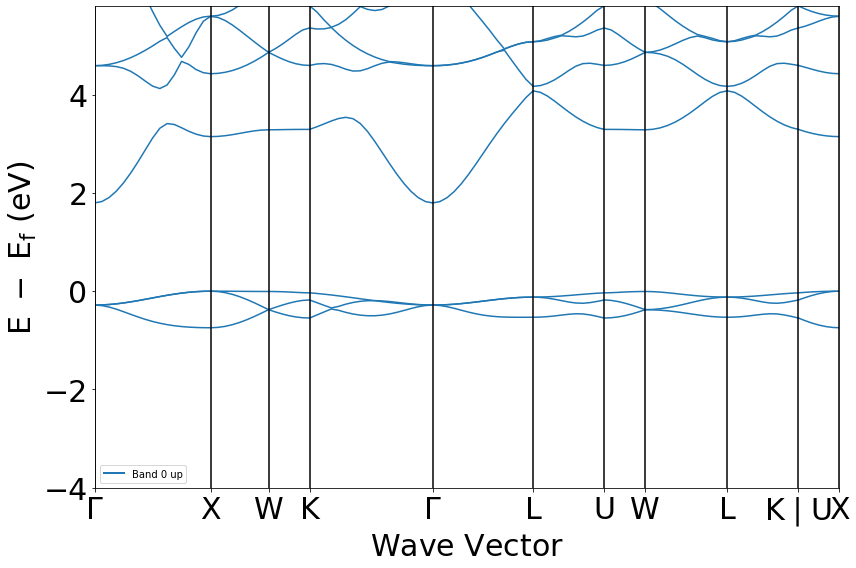

Pour la dernière bande de valence, on observe une dispersion minimale sur le segment X-W et maximale sur le segment Gamma-X
Pour la première bande de conduction, la dispersion est minimale sur le segment W-K et maximale sur le segment Gamma-L


In [19]:
# On reprend la figure précédente et on montre les directions de plus grandes pentes.
base_plot = plotter.get_plot(zero_to_efermi=True, ylim=None)
for items_list in [slope_seg_v["min_slope"], slope_seg_v["max_slope"], slope_seg_c["min_slope"], slope_seg_c["max_slope"]]:
    if items_list[0] >= 0:
        c = 'g'
    else:
        c = 'r'
    plt.arrow(x=items_list[1], y=items_list[2], dx=items_list[3], dy=items_list[4], color=c, linewidth=5, head_width=0.08, length_includes_head=True)

# On montre aussi le gap d'énergie, pour pouvoir mieux distinguer la position des extrema
plt.plot([0, dist_in_k[-1]], [0, 0], "y--")
plt.plot([0, dist_in_k[-1]], [1.7961, 1.7961], "y--")
plotter.show()
print("Pour la dernière bande de valence, on observe une dispersion minimale sur le segment X-W et maximale sur le segment Gamma-X")
print("Pour la première bande de conduction, la dispersion est minimale sur le segment W-K et maximale sur le segment Gamma-L")

In [24]:
# La masse est calculée sur les extréma, soit lorsque la dispersion est minimale. 
# En utilisant le modèle de la masse effective vu au cours, on peut déterminer la masse m
# telle que son inverse est la dérivée seconde de la bande d'énergie

# Il y a 2 minima dans la première bande de conduction et 3 maxima dans la dernière bande de valence
# Nous calculons une seule masse effective, selon une direction (dans un seul segment), pour chacun 
# (sauf le dernier en limite de domaine)
# Nous choisissons de considérer les points qui sont à droite, au plus proche de l'extrémum dans le graphe

# Lieu des sommets/bases, leurs positions et des dérivées secondes
cond_index = [0, 4]
val_index = [1, 7, 10]
positions = ["Gamma, direction X", "X, direction W", "Gamma, direction L", "W, direction L"]
band_name = ["conduction", "valence", "conduction", "valence"]
d2Edk2 = []

for i, k_interval in enumerate(all_dist):
    for ic in cond_index:
        if i == ic:
            dk2 = (k_interval[1]-k_interval[0])*(k_interval[2]-k_interval[1])
            E_cond = E_bands[i][band_c]
            # approximation numérique
            d2Edk2.append((E_cond[0]+E_cond[2]-2*E_cond[1])/dk2)
    for iv in val_index:
        if i == iv:
            dk2 = (k_interval[1]-k_interval[0])*(k_interval[2]-k_interval[1])
            E_val = E_bands[i][band_v]
            d2Edk2.append((E_val[0]+E_val[2]-2*E_val[1])/dk2)

print("Voici les masses effectives d'un électron exprimées en unités atomiques")
for i in range(len(d2Edk2)):
    print("Au point", positions[i], "( bande de", band_name[i], "), la masse vaut", d2Edk2[i])

Voici les masses effectives d'un électron exprimées en unités atomiques
Au point Gamma, direction X ( bande de conduction ), la masse vaut 22.972263958033945
Au point X, direction W ( bande de valence ), la masse vaut -0.21389445026099804
Au point Gamma, direction L ( bande de conduction ), la masse vaut 22.795801948400875
Au point W, direction L ( bande de valence ), la masse vaut -2.2646070392172244
